## Imports

In [2]:
import glob
from typing import List

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Loading Data

In [3]:
original_img_paths = glob.glob("./original_images_cs558_bw1/*")

In [4]:
original_img_paths

['./original_images_cs558_bw1/red.pgm',
 './original_images_cs558_bw1/plane.pgm',
 './original_images_cs558_bw1/kangaroo.pgm']

In [5]:
from util import ops

In [6]:
original_images_list = [
    ops.load_pgm(filename) for filename in original_img_paths
]

Dimensions of ./original_images_cs558_bw1/red.pgm: 321 x 481
Dimensions of ./original_images_cs558_bw1/plane.pgm: 481 x 321
Dimensions of ./original_images_cs558_bw1/kangaroo.pgm: 481 x 321


In [5]:
original_images_dict = dict(zip(
    ["Red", "Plane", "Kangaroo"], original_images_list
))

## Part 1: Gaussian Filtering of the Input Image

Based on an earlier run of this code, we visualized Gaussian smoothening of all 3 images using `sigma` values from 1 to 10:
![All the images + their smoothed versions, using sigma 1-10](./part_1_smoothed_images/attempt-1-incorrect-padding.png)

Unfortunately, these images got clipped accidentally because I messed up my zero padding function 😅.
So for the visualization below - we'll run the smoothening function again. And as per the submission requirements, we'll only use 2 different `sigma` values - specifically, `3` and `8`:

In [6]:
from mpl_toolkits.axes_grid1 import ImageGrid
from util.gaussian_derivative import GaussianDerivativeFilter

In [7]:
# get a 1D array of all the images, smoothed at all values of sigma:
smoother = GaussianDerivativeFilter()
smoothed_images_all2 = list()
sigma_values = [3, 8]  # originally, this was len(range(1, 11))

for image_name, image in original_images_dict.items():
    # first, add the normal image for comparison later on
    smoothed_images = [(image_name, image)]
    for sigma in sigma_values:
        filter_matrix = smoother.create_gaussian_filter(sigma)
        smoothed_image = smoother.smooth(image, filter_matrix, padding_type="repeat")
        smoothed_images.append((image_name, smoothed_image))
    smoothed_images_all2.extend(smoothed_images)


In [8]:
# checking dims of the convolutions - purely a sanity check
new_im_count = 0
for _, im  in smoothed_images_all2:
    print(len(im), len(im[0]))
    new_im_count= (new_im_count + 1)
    if new_im_count % 3 == 0:
        print("-------------")

481 321
481 321
481 321
-------------
321 481
321 481
321 481
-------------
321 481
321 481
321 481
-------------


In [9]:
from PIL import Image

In [10]:
i = 0
for _, raster_matrix in smoothed_images_all2:
    arr = np.asarray(raster_matrix).astype(np.uint8)
    im = Image.fromarray(arr)
    i += 1
    im.save(f"./part_1_smoothed_images/{i}_repeat_padding.png")

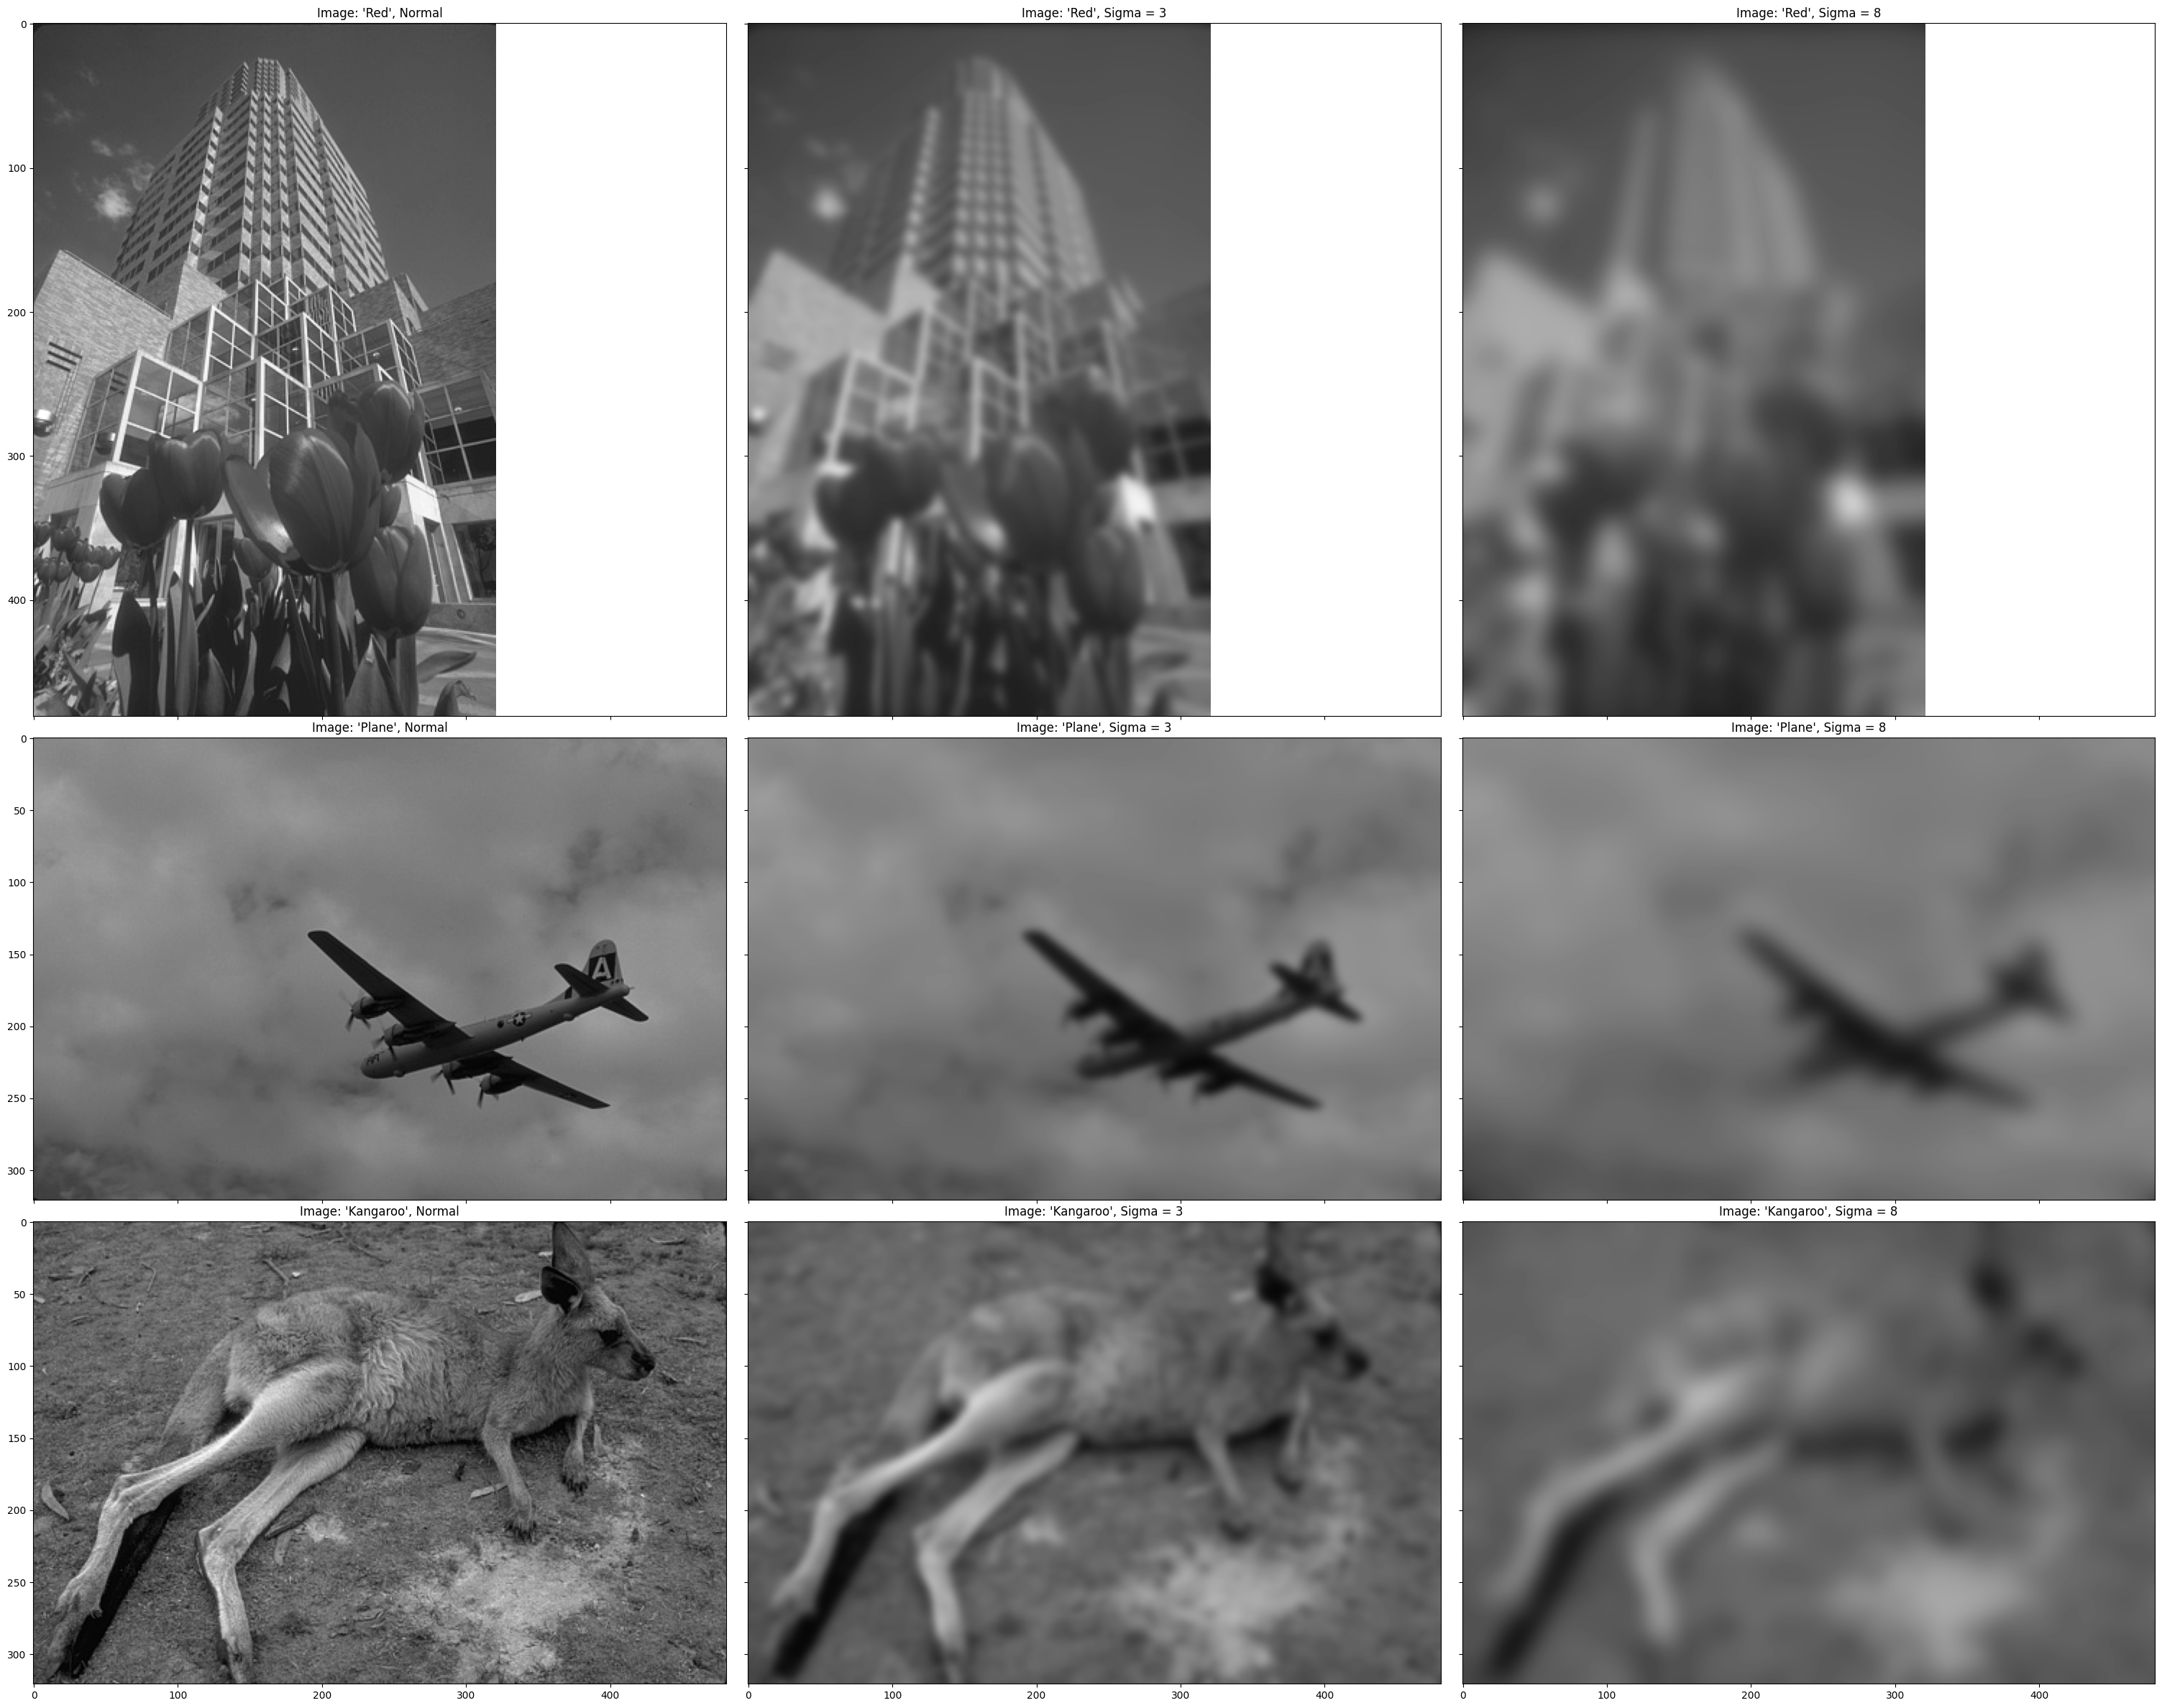

In [11]:
fig = plt.figure(figsize=(400., 30.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(3, 3),  # creates 3x3 grid of axes
                 axes_pad=0.3,  # pad between axes in inch.
                )

image_index_to_name = {
    1: "Red",
    2: "Plane",
    3: "Kangaroo"
}
plot_index = 0
for ax, im in zip(grid, smoothed_images_all2):
    # show image
    ax.imshow(im[1], cmap='gray', vmin=0, vmax=255)

    # configure plot title
    sigma = None
    if plot_index % 3 == 0:
        sigma = "Normal"
    elif plot_index % 3 == 1:
        sigma = "Sigma = 3"
    elif plot_index % 3 == 2:
        sigma = "Sigma = 8"
    
    image_name = image_index_to_name[plot_index // 3 + 1]
    plot_title = f"Image: '{image_name}', {sigma}"

    grid.axes_all[plot_index].set_title(plot_title)

    plot_index += 1

plt.show()

### Checking our Solution, using `scipy`

In [12]:
from scipy import ndimage

In [13]:
plane = original_images_dict["Plane"]

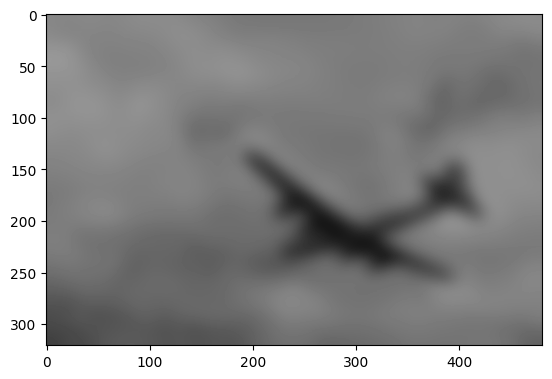

In [14]:
# applying the Gaussian to the image
smooth_plane = ndimage.gaussian_filter(plane, sigma=8)
plt.imshow(smooth_plane, cmap='gray', vmin=0, vmax=255)
plt.show()

Looks good to me! :)

## Part 2: Gradient Computation using the Sobel filters

### The "Kangaroo" Image

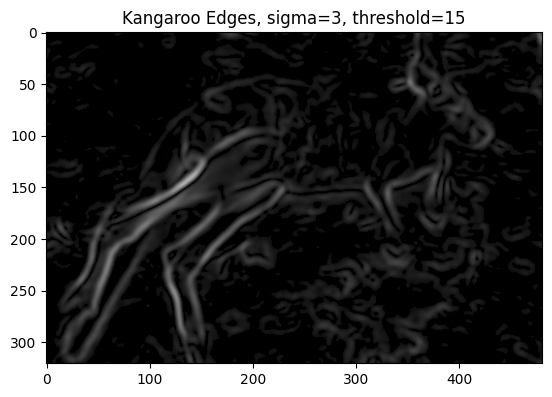

In [15]:
_ = GaussianDerivativeFilter.detect_edges_and_visualize(
    original_images_dict["Kangaroo"],
    "Kangaroo", 3, 15,
    padding_type="repeat"
)

### The "Plane" Image

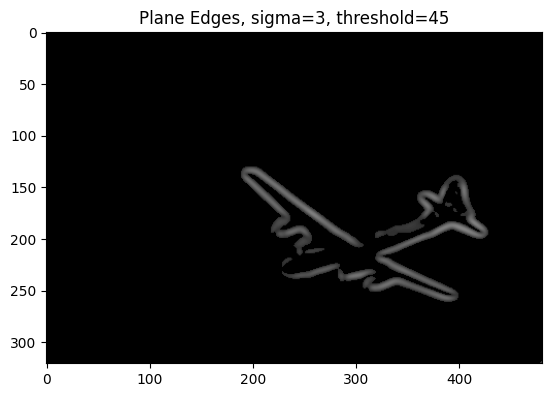

In [16]:
_ = GaussianDerivativeFilter.detect_edges_and_visualize(
    original_images_dict["Plane"],
    "Plane", 3, 45,
    padding_type="repeat"
)

### The "Red" Image

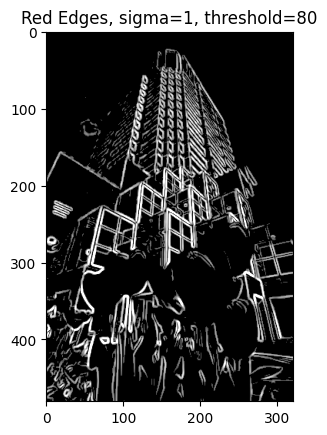

In [17]:
_ = GaussianDerivativeFilter.detect_edges_and_visualize(
    original_images_dict["Red"],
    "Red", 1, 80,
    padding_type="repeat"
)

### Checking Our Solution

In [18]:
from scipy import signal

In [19]:
plane = original_images_dict["Plane"]

In [20]:
smooth_plane = ndimage.gaussian_filter(plane, sigma=3)

plane_horizontal_gradient = ndimage.sobel(smooth_plane, 0)
plane_vertical_gradient = ndimage.sobel(smooth_plane, 1)

plane_magnitude = np.sqrt(
    (plane_horizontal_gradient ** 2) + (plane_vertical_gradient ** 2)
)

# and of course, applying the threshold
plane_magnitude = np.where(
    plane_magnitude > 45, plane_magnitude, 0
)

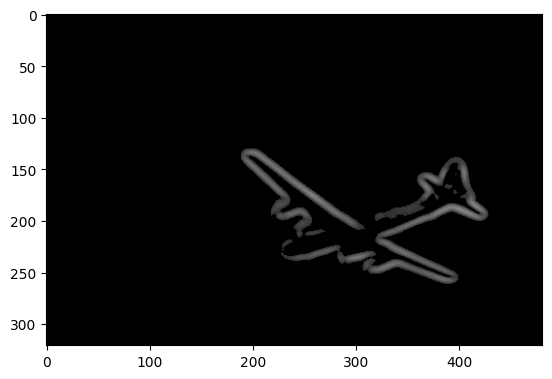

In [21]:
plt.imshow(plane_magnitude, cmap='gray', vmin=0, vmax=255)
plt.show()

Looks like it matches up! :) 

## Part 3: Non-Maximum Suppression

### The "Kangaroo" Image

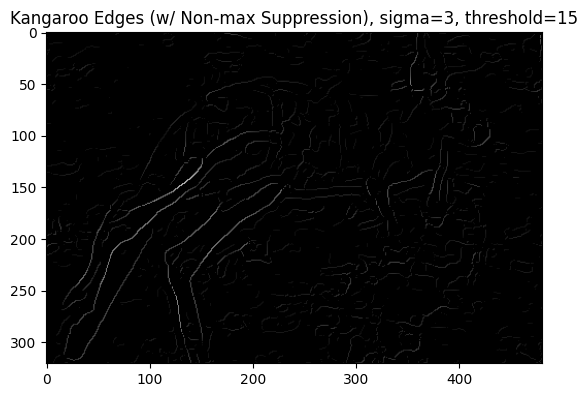

In [22]:
_ = GaussianDerivativeFilter.detect_edges_and_visualize(
    original_images_dict["Kangaroo"],
    "Kangaroo", 3, 15,
    use_non_max_suppression=True,
    padding_type="repeat"
)

### The "Plane" Image

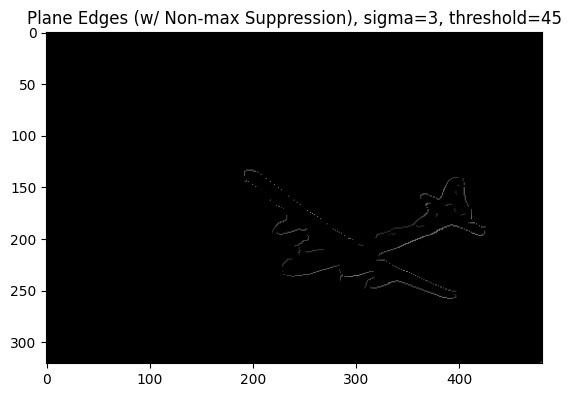

In [23]:
_ = GaussianDerivativeFilter.detect_edges_and_visualize(
    original_images_dict["Plane"],
    "Plane", 3, 45,
    use_non_max_suppression=True,
    padding_type="repeat"
)

### The "Red" Image

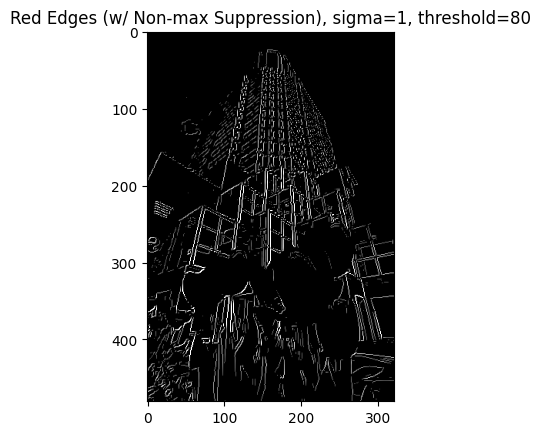

In [24]:
_ = GaussianDerivativeFilter.detect_edges_and_visualize(
    original_images_dict["Red"],
    "Red", 1, 80,
    use_non_max_suppression=True,
    padding_type="repeat"
)

### TODO: Check Our Solution

Haven't been able to find good libraries to do this yet... will ask TA.